# Crystal plasticity formulations

There are two common ways to formulate crystal plasticity kinematic:
1. Integrate the elastic stretch and elastic rotation separately with two (coupled) rate equations.
2. Integrate the plastic deformation gradient $F_p$ directly from $l_p$.  Calculate the elastic deformation in postprocessing through the usual multiplicative decomposition of $F = F_e F_p$.

It's easy to formulate a crystal model either way in NEML2, reusing most of detailed constitutive model objects like the hardening law, the slip law, and the crystal geometry.  In fact the vast majority of the objects are shared between the two models with only a few specialized models required for each.

This example runs equivalent separated and multplicative models through the same deformation history (rolling to 50% rolling strain) and plots a comparison.  You can also use this notebook to look at differences in performance, though we have not done detailed performance optimization on either.

## Importing required libraries and setting up

This example will run on the GPU with CUDA if available.  `nchunk` is the chunk size for the `pyzag` integration, `ncrystal` is the number of random initial crystal orientations to use.

This example simulates rolling in an FCC material.  `rate` sets the strain rate, `total_rolling_strain` the reduction strain, and `ntime` the number of time steps to take.

We need to calculate both the deformation rate/vorticity and the deformation gradient

In [1]:
import matplotlib.pyplot as plt
import torch
import neml2
import neml2.tensors
from pyzag import nonlinear, chunktime
import neml2.postprocessing

In [2]:
torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

nchunk = 15
ncrystal = 500

In [3]:
rate = 0.0001
total_rolling_strain = 0.5
ntime = 2500
end_time = total_rolling_strain / rate
initial_orientations = neml2.tensors.Rot.fill_random(ncrystal).torch().to(device)

In [4]:
deformation_rate = torch.zeros((ntime, ncrystal, 6), device = device)
deformation_rate[:, :, 1] = rate
deformation_rate[:, :, 2] = -rate
times = torch.linspace(0, end_time, ntime, device = device).unsqueeze(-1).unsqueeze(-1).expand((ntime, ncrystal, 1))
vorticity = torch.zeros((ntime, ncrystal, 3), device = device)

In [5]:
# Now get the integrated deformation gradient
full_spatial_velocity_gradient = neml2.tensors.R2(neml2.tensors.SR2(deformation_rate)).torch() + neml2.tensors.R2(neml2.tensors.WR2(vorticity)).torch()
F = torch.zeros_like(full_spatial_velocity_gradient)
F[0] = torch.eye(3, device = device)
dt = torch.diff(times, dim = 0)
Finc = torch.linalg.matrix_exp(full_spatial_velocity_gradient[:-1] * dt.unsqueeze(-1))
for i in range(1, ntime):
    F[i] = Finc[i-1] @ F[i - 1]

## pyzag driver for the separate model

For more details on the pyzag driver used here see the deterministic and stochastic inference examples.  This helper object just lets us integrate the crystal model using pyzag

In [6]:

class SolveSeparate(torch.nn.Module):
    """Just integrate the model through some strain history

    Args:
        discrete_equations: the pyzag wrapped model
        nchunk (int): number of vectorized time steps
        rtol (float): relative tolerance to use for Newton's method during time integration
        atol (float): absolute tolerance to use for Newton's method during time integration
    """
    def __init__(self, discrete_equations, nchunk = 1, rtol = 1.0e-6, atol = 1.0e-8):
        super().__init__()
        self.discrete_equations = discrete_equations
        self.nchunk = nchunk
        self.rtol = rtol
        self.atol = atol

    def forward(self, time, deformation_rate, vorticity, initial_orientations = None):
        """Integrate through some time/temperature/strain history and return stress
        Args:
            time (torch.tensor): batched times
            deformation_rate (torch.tensor): batched deformation rates
            vorticity (torch.tensor): batched vocticities

        Keyword Args:
            initial_orientation (torch.tensor): if provided, the initial orientations for each crystal
        """
        solver = nonlinear.RecursiveNonlinearEquationSolver(
            self.discrete_equations, step_generator = nonlinear.StepGenerator(self.nchunk),
            predictor=nonlinear.PreviousStepsPredictor(), nonlinear_solver = chunktime.ChunkNewtonRaphson(rtol = self.rtol, atol = self.atol)
        )


        # Setup
        forces = self.discrete_equations.forces_asm.assemble_by_variable({'forces/t': time, 'forces/deformation_rate': deformation_rate, 'forces/vorticity': vorticity, 'forces/initial_orientation': initial_orientations}).torch()
        state0 = self.discrete_equations.state_asm.split_by_variable(neml2.Tensor(torch.zeros(forces.shape[1:-1] + (self.discrete_equations.nstate,), device = forces.device), 1))
        if initial_orientations is not None:
            state0['state/orientation'] = neml2.Tensor(initial_orientations, 1)
        state0 = self.discrete_equations.state_asm.assemble_by_variable(state0).torch()

        result =  nonlinear.solve_adjoint(
            solver, state0, len(forces), forces
        )

        return result

## Simulate rolling deformation for the seperated model

Simulate the rolling deformation and extract the final crystal orientations

In [7]:
nmodel_separate = neml2.load_model("crystal.i", "implicit_rate")
nmodel_separate.to(device = device)
model_separate = SolveSeparate(neml2.pyzag.NEML2PyzagModel(nmodel_separate), nchunk = nchunk)

In [8]:
with torch.no_grad():
    results_seperate = model_separate(times, deformation_rate, vorticity, initial_orientations = initial_orientations)
orientations_separate = neml2.tensors.Rot(results_seperate[-1,:,6:9], 1)

## ODF reconstruction for the seperate model

Reconstruct the ODF from the discrete data.  Uncommenting the two lines will optimize the kernel half-width with the built in routine (which uses a cross-validation approach).  However, for consistency between the two methods, we'll use a fixed half width for both.

In [9]:
odf_separate = neml2.postprocessing.odf.KDEODF(orientations_separate, neml2.postprocessing.odf.DeLaValleePoussinKernel(torch.tensor(0.2)))
#odf_separate.optimize_kernel(verbose = True)
#print(odf_separate.kernel.h)

## pyzag driver for the multiplicative model

Same thing as for the separated model, just now for the multiplicative form where we take the deformation gradient as input.  Don't forget to set the initial plastic deformation gradient to the identity!

In [10]:

class SolveMultiplicative(torch.nn.Module):
    """Just integrate the model through some strain history

    Args:
        discrete_equations: the pyzag wrapped model
        nchunk (int): number of vectorized time steps
        rtol (float): relative tolerance to use for Newton's method during time integration
        atol (float): absolute tolerance to use for Newton's method during time integration
    """
    def __init__(self, discrete_equations, nchunk = 1, rtol = 1.0e-6, atol = 1.0e-8):
        super().__init__()
        self.discrete_equations = discrete_equations
        self.nchunk = nchunk
        self.rtol = rtol
        self.atol = atol

    def forward(self, time, deformation_gradient, initial_orientations = None):
        """Integrate through some time/temperature/strain history and return stress
        Args:
            time (torch.tensor): batched times
            deformation_gradient (torch.tensor): batched deformation gradients

        Keyword Args:
            initial_orientation (torch.tensor): if provided, the initial orientations for each crystal
        """
        solver = nonlinear.RecursiveNonlinearEquationSolver(
            self.discrete_equations, step_generator = nonlinear.StepGenerator(self.nchunk),
            predictor=nonlinear.PreviousStepsPredictor(), nonlinear_solver = chunktime.ChunkNewtonRaphson(rtol = self.rtol, atol = self.atol)
        )

        # Setup
        forces = self.discrete_equations.forces_asm.assemble_by_variable({'forces/t': time, 'forces/F': deformation_gradient.flatten(start_dim=-2), 'forces/r': initial_orientations.unsqueeze(0).expand(time.shape[:-1]+(3,))}).torch()
        state0 = self.discrete_equations.state_asm.split_by_variable(neml2.Tensor(torch.zeros(forces.shape[1:-1] + (self.discrete_equations.nstate,), device = forces.device), 1))
        state0['state/Fp'] = neml2.tensors.Tensor(torch.eye(3, device = time.device).unsqueeze(0).expand(time.shape[1:2]+(3,3)), 1)
        state0 = self.discrete_equations.state_asm.assemble_by_variable(state0).torch()

        result =  nonlinear.solve_adjoint(
            solver, state0, len(forces), forces
        )

        return result

## Simulate for the multiplicative model
Again, simulate rolling deformation

In [11]:
nmodel_mult = neml2.reload_model("crystal_multiplicative.i", "implicit_rate")
nmodel_mult.to(device = device)
model_mult = SolveMultiplicative(neml2.pyzag.NEML2PyzagModel(nmodel_mult), nchunk = nchunk)

In [12]:
with torch.no_grad():
    results_mult = model_mult(times, F, initial_orientations = initial_orientations)
end_results_mult = results_mult[-1]

## Extract the orientations for the multiplicative model

This takes some doing.  We first need to get $F_p$ from the state, then calculate $F_e = F F_p^{-1}$, then do a polar decomposition to get the rotation as a matrix, then convert to modified Rodrigues parameters.  Finally compose with the original texture to get the final, deformed texture.

In [13]:
split_state = model_mult.discrete_equations.state_asm.split_by_variable(neml2.Tensor(end_results_mult,1))
Fp = split_state["state/Fp"].torch().reshape(-1,3,3)
Flast = F[-1]
Fe = Flast @ torch.linalg.inv(Fp)
U, S, Vh = torch.linalg.svd(Fe)
Re = U @ Vh
Ue = Vh.transpose(-2,-1).conj() @ torch.diag_embed(S, dim1=-2, dim2=-1)  @ Vh
Re_mrp = neml2.tensors.Rot.fill_matrix(neml2.tensors.R2(Re, 1))

Q0 = neml2.tensors.Rot(initial_orientations, 1)
Q = Re_mrp * Q0

## Construct the ODF for the multiplicative model results

Basically the same as for the separated approach.

In [14]:
odf_mult = neml2.postprocessing.odf.KDEODF(Q, neml2.postprocessing.odf.DeLaValleePoussinKernel(torch.tensor(0.2)))
#odf_mult.optimize_kernel(verbose = True)
#print(odf_mult.kernel.h)

## Plot the pole figures

Use the reconstructed ODFs to plot continuous 111 polefigure

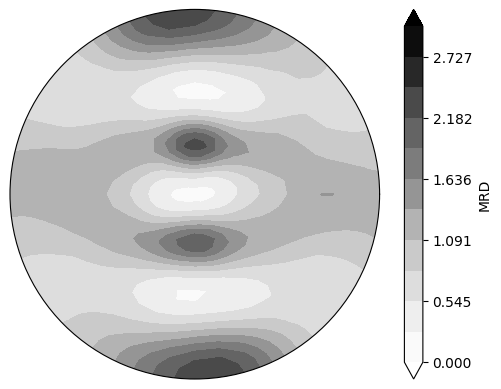

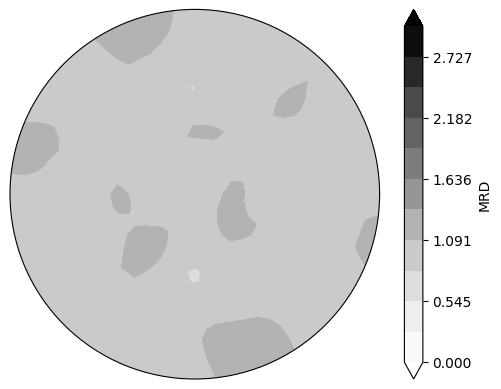

In [15]:
neml2.postprocessing.pretty_plot_pole_figure_odf(odf_separate, torch.tensor([1,1,1.0], device = device), crystal_symmetry = "432", limits = (0.0, 3.0), ncontour = 12)
neml2.postprocessing.pretty_plot_pole_figure_odf(odf_mult, torch.tensor([1,1,1.0], device = device), crystal_symmetry = "432", limits = (0.0, 3.0), ncontour = 12)

## Plot some comparisons of the elastic strains

Extract the elastic strains from each model and plot:
1. The history of each crystal over time
2. The average over time

The averages are consistent but there are some differences in stress/elastic strain history between crystals when calculated this way.

Text(0, 0.5, 'Elastic strain in the rolling direction')

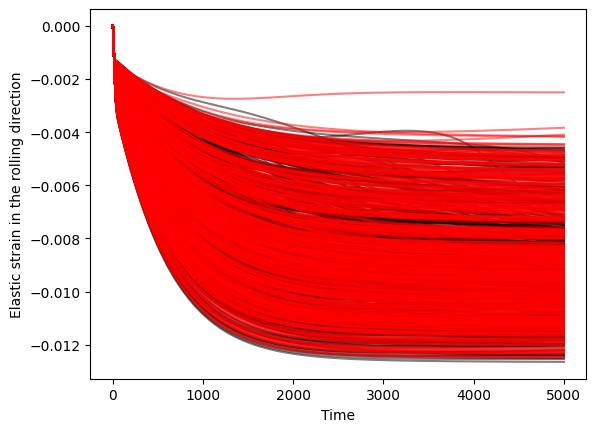

In [16]:
state_history_split = model_separate.discrete_equations.state_asm.split_by_variable(neml2.Tensor(results_seperate,2))
state_history_mult = model_mult.discrete_equations.state_asm.split_by_variable(neml2.Tensor(results_mult,2))

Fp_mult = state_history_mult["state/Fp"].torch().reshape(F.shape[:-2] + (3,3))
Fe_mult = F @ torch.linalg.inv(Fp_mult)
U_mult, S_mult, Vh_mult = torch.linalg.svd(Fe_mult)
Re_mult = U_mult @ Vh_mult
Ue_mult = Vh_mult.transpose(-2,-1).conj() @ torch.diag_embed(S_mult, dim1=-2, dim2=-1)  @ Vh_mult
E_mult = 0.5*(Ue_mult.transpose(-2,-1) @ Ue_mult - torch.eye(3, device = device))

plt.plot(times[:,0,0].cpu(), state_history_split["state/elastic_strain"].torch()[:,:,2].cpu(), 'k-', alpha = 0.5)
plt.plot(times[:,0,0].cpu(), E_mult[:,:,2,2].cpu(), 'r-', alpha = 0.5)
plt.xlabel("Time")
plt.ylabel("Elastic strain in the rolling direction")

Text(0, 0.5, 'Elastic strain')

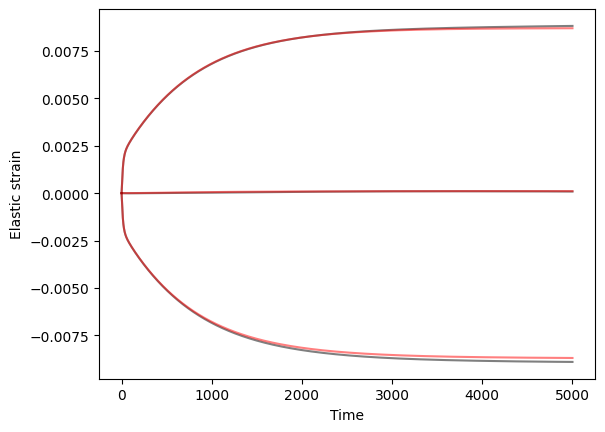

In [17]:
for i in range(3):
    plt.plot(times[:,0,0].cpu(), torch.mean(state_history_split["state/elastic_strain"].torch()[:,:,i], dim = -1).cpu(), 'k-', alpha = 0.5)
    plt.plot(times[:,0,0].cpu(), torch.mean(E_mult[:,:,i,i], dim = -1).cpu(), 'r-', alpha = 0.5)
plt.xlabel("Time")
plt.ylabel("Elastic strain")
